<h1>Building classifier models for the MNIST dataset</h1>

In this notebook we will create multiple models to classify digits from the handwritten MNIST digit dataset.

In [1]:
from sklearn import datasets
digits = datasets.load_digits()
list(digits.keys())

['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']

Let's inspect some of the dataset first.

In [50]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [51]:
y.shape

(1797,)

In [52]:
%matplotlib inline 
#so that the plot will be displayed in the notebook
import numpy as np
np.random.seed(42)

import matplotlib
from matplotlib import pyplot as plt

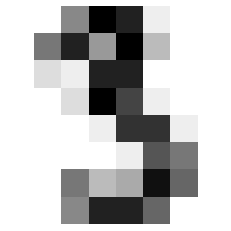

In [53]:
some_digit = X[3]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[3]

3

<h2>Preprocessing and training binary classifiers</h2>

Firstly splitting the data into the training set (X) and test set (y) using StratifiedShuffleSplit in order go get stratified sampling of the digit distribution.

In [10]:
#Split into training and test data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=50, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


Now onto binary classification, for this we are going to determine whether a digit is or is not a specific chosen digit. For these examples 0 will be used. The training data must therefore be modified to show 0s or not 0s.

In [11]:
test_digit = 0
y_train_digit = (y_train == test_digit) # will return True when the label is 9
y_test_digit = (y_test == test_digit)
zero_example = X_test[5] #a known digit 0 in the test set
six_example = X_test[4] 
seven_example = X_test[0] 
zero_example

array([ 0.,  0.,  2., 15., 13.,  2.,  0.,  0.,  0.,  0.,  8., 16., 15.,
       12.,  0.,  0.,  0.,  0.,  9., 14.,  1., 15.,  5.,  0.,  0.,  0.,
       14., 13.,  0., 11.,  9.,  0.,  0.,  3., 16., 11.,  0., 12.,  9.,
        0.,  0.,  2., 16.,  3.,  2., 16.,  6.,  0.,  0.,  1., 13., 11.,
       15., 14.,  0.,  0.,  0.,  0.,  4., 16., 15.,  5.,  0.,  0.])

Then training a perceptron on the modified training data

In [12]:
import pandas as pd
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, tol=None, random_state=50,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd.fit(X_train, y_train_digit)


SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', max_iter=5,
              penalty=None, random_state=50, tol=None)

Now analysing the predictions made by the model using a table of results

In [13]:
#Function to highlight cells green or red depending on test results
def highlight_results(s):
    if s.Prediction == s.Actual:
        return ['background-color: lightgreen']*3
    else:
        return ['background-color: lightcoral']*3

In [14]:
def draw_results_table(model, num_tests):
    predictions = []
    answers = []
    index = []

    #Gets results from the test data
    for i in range(num_tests):
        p = model.predict([X_test[i]])
        a = y_test_digit[i]
        predictions.append(p[0])
        answers.append(a)
        index.append(y_test[i])

    #Pandas dataframe to display the data
    df = pd.DataFrame({
    "Digit": index,
    "Prediction": predictions,
    "Actual": answers,
    })
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    return df.style.hide_index().apply(highlight_results, axis=1)
    
draw_results_table(sgd, 6)

Digit,Prediction,Actual
7,False,False
3,False,False
3,False,False
3,False,False
6,False,False
0,True,True


An initial look at the results show the perceptron model can predict 0s and not 0s as shown above.
Now moving on to Logistic regression.

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000000) #max iterations must be increased due to nature of the problem
log_reg.fit(X_train, y_train_digit)
log_reg.predict([zero_example])

array([ True])

In [16]:
draw_results_table(log_reg, 6)

Digit,Prediction,Actual
7,False,False
3,False,False
3,False,False
3,False,False
6,False,False
0,True,True


Logistic regression appears to be able to predict 0s and not 0s. Now moving onto Naive Bayes classification

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

#gnb = MultinomialNB() # or:
gnb = GaussianNB() 
gnb.fit(X_train, y_train_digit)
gnb.predict([zero_example])

array([ True])

In [18]:
draw_results_table(gnb, 6)

Digit,Prediction,Actual
7,False,False
3,False,False
3,False,False
3,False,False
6,False,False
0,True,True


And finally, the Naive Bayes classifier appears to be able to predict 0s and not 0s.

<h2>Evaluating the models<\h2>

Firstly looking at the accuracy score for each model 

In [19]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(log_reg, X_train, y_train_digit, cv=5, scoring="accuracy"), "-> Logistic regression")
print(cross_val_score(gnb, X_train, y_train_digit, cv=5, scoring="accuracy"), "-> Naive Bayes")
print(cross_val_score(sgd, X_train, y_train_digit, cv=5, scoring="accuracy"), "-> Simple perceptron")

[1.         1.         0.99651568 1.         0.99303136] -> Logistic regression
[0.98263889 0.98958333 0.98954704 0.98954704 0.9825784 ] -> Naive Bayes
[1.         1.         0.99651568 0.99303136 0.99303136] -> Simple perceptron


For 0s and not 0s all 3 have high scores, however if the test digit is 8 (i.e. classifying 8s and not 8s) Naive Bayes performs significantly poorly (accuracy of roughly 0.5 which is the worst possible score). Now onto looking at confusion matrices for the logistic regression and naive Bayes.

|                  | predicted $\hat c=0$| predicted $\hat c=1$ |
|  -------------   |   :-------------:   |    :-------------:   |
| **actual $c=0$** | TN                  |   FP                 |
| **actual $c=1$** | FN                  |   TP                 |

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

#Logistic regression
y_train_pred = cross_val_predict(log_reg, X_train, y_train_digit, cv=5)
confusion_matrix(y_train_digit, y_train_pred)

array([[1294,    1],
       [   2,  140]], dtype=int64)

In [21]:
#Naive Bayes
y_train_pred = cross_val_predict(gnb, X_train, y_train_digit, cv=5)
confusion_matrix(y_train_digit, y_train_pred)

array([[1278,   17],
       [   2,  140]], dtype=int64)

As shown above, for 0s the Naive Bayes model has more false positives than logistic regression. Now onto investigating precision, recall, and f1 score.<br>Firstly for logistic regression (precision, recall ,f1):

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [24]:
y_train_pred = cross_val_predict(log_reg, X_train, y_train_digit, cv=5)
precision = precision_score(y_train_digit, y_train_pred)
recall = recall_score(y_train_digit, y_train_pred) 
f1 = f1_score(y_train_digit, y_train_pred)
print(precision, recall, f1)

0.9929078014184397 0.9859154929577465 0.9893992932862191


And now for Naive Bayes:

In [25]:
y_train_pred = cross_val_predict(gnb, X_train, y_train_digit, cv=5)
precision = precision_score(y_train_digit, y_train_pred)
recall = recall_score(y_train_digit, y_train_pred) 
f1 = f1_score(y_train_digit, y_train_pred)
print(precision, recall, f1)

0.89171974522293 0.9859154929577465 0.9364548494983277


The above results show that Naive Bayes has signifcantly lower precision for the binary classification

<h2>Precision and recall graphs and ROC curve</h2>

Firstly getting the confidence values for each digit in the training set

In [26]:
y_scores = cross_val_predict(log_reg, X_train, y_train_digit, cv=5, method="decision_function")
y_scores

array([-29.52501307, -11.23586758,  -6.58755911, ..., -13.71664323,
       -23.25836066, -15.27974195])

Now plotting precision and recall against the confidence threshold

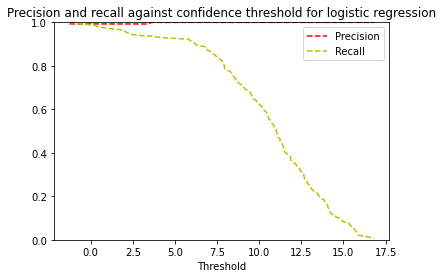

In [27]:
from sklearn.metrics import precision_recall_curve
  
precisions, recalls, thresholds = precision_recall_curve(y_train_digit, y_scores)

def plot_pr_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "y--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])
    plt.title("Precision and recall against confidence threshold for logistic regression")
    
plot_pr_vs_threshold(precisions, recalls, thresholds)
plt.show()

The graph shows that at a threshold of 0 precision and recall are extremely high, with precision increasing marginally to 1 at a threshold of around 3.5. When the test digit is 8 the graph shows a more normal relationship between precision and recall, as recall decreases precision increases with their crossover at a threshold of 0.<br>
Now onto plotting precision against recall

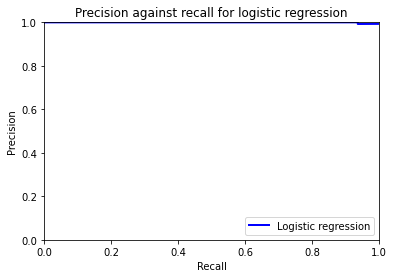

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2, label="Logistic regression")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="lower right")
    plt.title("Precision against recall for logistic regression")


plot_precision_vs_recall(precisions, recalls)
plt.show()

As shown above, for classifying 0s the logistic regression model is nearly perfect. Now onto plotting the ROC curve

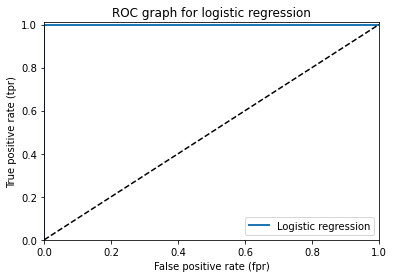

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_digit, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label="Logistic regression")
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.legend(loc="lower right")
    plt.title("ROC graph for logistic regression")


    
plot_roc_curve(fpr, tpr)
plt.show()

Once again the graph shows the model is performing well against the test data. Now calculating the area under the ROC curve

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_digit, y_scores)

0.9999510576975366

A perfect classifier has an AUC of 1 hence this classifier is performing excellently so far. Now shoing the ROC curve of both the Naive Bayes and logistic regression

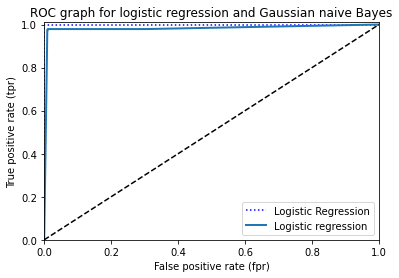

In [31]:
y_probas_gnb = cross_val_predict(gnb, X_train, y_train_digit, cv=3, method="predict_proba")
y_scores_gnb = y_probas_gnb[:, 1] # score = proba of the positive class
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_train_digit, y_scores_gnb)

plt.plot(fpr, tpr, "b:", label="Logistic Regression")
plot_roc_curve(fpr_gnb, tpr_gnb, "Gaussian Naive Bayes")
plt.legend(loc="lower right")
plt.title("ROC graph for logistic regression and Gaussian naive Bayes")
plt.show()

As shown the logistic regression model performs slightly better than the Naive Bayes

<h2>Data transformations</h2>

Firstly applying kernel trick (higher dimensions) to the simple perceptron

In [32]:
from sklearn.kernel_approximation import RBFSampler

rbf_features = RBFSampler(gamma=1, random_state=42)
X_train_features = rbf_features.fit_transform(X_train)
print(X_train.shape, "->", X_train_features.shape)
sgd_rbf = SGDClassifier(max_iter=100, random_state=42, loss="perceptron", 
                        eta0=1, learning_rate="constant", penalty=None)
sgd_rbf.fit(X_train_features, y_train_digit) 

sgd_rbf.score(X_train_features, y_train_digit)

(1437, 64) -> (1437, 100)


0.8970076548364648

This in fact results in a slightly worse accuracy score for the model. Now analysing precision, recall, and F1

In [33]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_digit, cv=5)
precision = precision_score(y_train_digit, y_train_pred)
recall = recall_score(y_train_digit, y_train_pred)
f1 = f1_score(y_train_digit, y_train_pred)
print(precision, recall, f1, "<- Unmodified data")

y_train_pred = cross_val_predict(sgd_rbf, X_train_features, y_train_digit, cv=5)
precision = precision_score(y_train_digit, y_train_pred)
recall = recall_score(y_train_digit, y_train_pred)
f1 = f1_score(y_train_digit, y_train_pred)
print(precision, recall, f1, "<- Transformed data")

0.9858156028368794 0.9788732394366197 0.9823321554770318 <- Unmodified data
0.01904761904761905 0.014084507042253521 0.016194331983805668 <- Transformed data


Applying kernel trick here has actually decreased all 3 measures of performance significantly hence it's best to keep the data unmodified for now

<h2>Multiclass classification</h2>

Firstly appling the perceptron on all classes using one vs all

In [34]:
sgd.fit(X_train, y_train) # i.e., all instances, not just one class
print(sgd.predict([zero_example]))
print(sgd.predict([six_example]))

[0]
[6]


Checking the motivation behind it using confidence thresholds

In [35]:
zero_scores = sgd.decision_function([zero_example])
print(zero_scores)

# check which class gets the maximum score
prediction = np.argmax(zero_scores)
print(prediction)

[[ 1748. -9021. -9183. -7811. -4422. -6033. -7197. -7738. -7682. -3997.]]
0


Now trying the one vs one strategy

In [36]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=100, random_state=42, loss="perceptron", 
                                           eta0=1, learning_rate="constant", penalty=None))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([zero_example])

array([0])

Now applying Naive Bayes to all the classes

In [37]:
gnb.fit(X_train, y_train)
print(gnb.predict([zero_example]))
gnb.predict_proba([zero_example])

[0]


array([[1.00000000e+000, 6.31653055e-043, 1.91127581e-196,
        1.80240700e-185, 7.67240288e-029, 4.14981222e-070,
        0.00000000e+000, 0.00000000e+000, 8.12517279e-130,
        1.47022338e-057]])

Inspecting the accuracy scores across for multiple classification of all 3 models

In [38]:
print(cross_val_score(sgd, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_clf, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train, y_train, cv=5, scoring="accuracy"))

[0.92361111 0.93055556 0.90940767 0.93031359 0.90940767]
[0.97222222 0.95486111 0.95470383 0.96864111 0.95818815]
[0.83680556 0.81597222 0.81184669 0.85017422 0.82926829]


One vs one simple perceptron appears to be the best, now onto scaling the data to try ad increase performance

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print(cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_clf, X_train_scaled, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train_scaled, y_train, cv=5, scoring="accuracy"))

[0.92013889 0.92013889 0.92334495 0.92682927 0.89547038]
[0.95486111 0.95833333 0.94773519 0.96864111 0.93379791]
[0.78125    0.75       0.77003484 0.80487805 0.77351916]


Scaling has in fact decreased performance and hence will not be used

<h2>Error analysis<\h2>

Plotting the distribution of the simple perceptron in a confusion matrix

In [40]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[141,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 130,   3,   4,   5,   0,   2,   0,   0,   1],
       [  0,   3, 138,   0,   0,   0,   0,   1,   0,   0],
       [  0,   1,   2, 139,   0,   1,   0,   2,   0,   1],
       [  0,   0,   0,   0, 143,   0,   0,   1,   1,   0],
       [  1,   0,   1,   0,   1, 141,   1,   0,   0,   1],
       [  0,   1,   0,   0,   2,   0, 141,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0, 139,   0,   3],
       [  0,  13,   5,  10,   1,   3,   7,   1,  98,   1],
       [  0,   5,   1,   1,   4,   2,   0,   3,   1, 127]], dtype=int64)

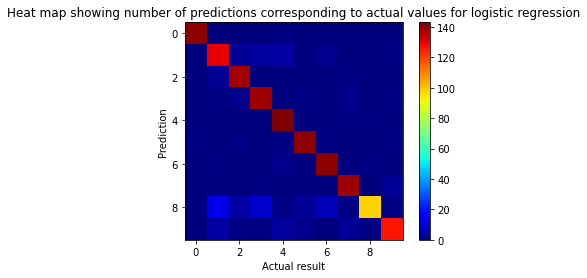

In [41]:
im = plt.imshow(conf_mx, cmap = "jet")
plt.colorbar(im)
plt.title("Heat map showing number of predictions corresponding to actual values for logistic regression")
plt.xlabel("Actual result")
plt.ylabel("Prediction")
plt.show()

As shown above the perceptron struggles to classify 8s the most and 0s are one of its more confident digits. Now making the most significant errors more prominant

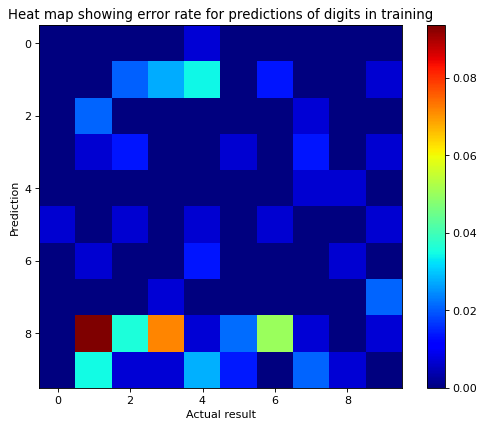

In [42]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
im = plt.imshow(norm_conf_mx, cmap = "jet")
plt.colorbar(im)
plt.title("Heat map showing error rate for predictions of digits in training")
plt.xlabel("Actual result")
plt.ylabel("Prediction")
plt.show()


As shown above, the classifier interestingly struggles the most with distinguishing between 8s and 1s

<h2>Final evaluations on the test set<\h2>

Firstly evaluating the simple perceptron with scaling and kernel trick

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_features = rbf_features.transform(X_test)
X_test_features_scaled = scaler.fit_transform(X_test_features.astype(np.float64))
y_pred = sgd_rbf.predict(X_test_features_scaled)
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='weighted',zero_division=False)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(accuracy, precision, recall, f1)

0.09166666666666666 0.01909341193351499 0.09166666666666666 0.03144738051359444


Evidently extremely poor results hence scaling and kernel trick should not be used with the simple perceptron

Now evaluating the one vs one perceptron without scaling or kernel trick

In [45]:
y_pred = ovo_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9694444444444444

In [46]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(precision, recall, f1)

0.9702662091916479 0.9694444444444444 0.9695944146004564


Evidently much better results with high scores on all 4 measures. <br> Now evaluating Guassian Naive Bayes

In [47]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy_score(y_test, y_pred)

0.8305555555555556

In [48]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(precision, recall, f1)

0.8623357277794652 0.8305555555555556 0.8288976479140596


A decent performance across all 4 measures but in terms of perfomance Naive Bayes has been beaten by the simple perceptron.